<a href="https://colab.research.google.com/github/Sharini-19/SpeechEmotion-Realtime_ML/blob/main/SpeechEmotionRecognition_Realtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffmpeg-python
import pandas as pd
import numpy as np
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

def ravdess_data():
  ravdess = "/content/drive/MyDrive/Audiofiles/Audiofiles/audio_speech_actors_01-24/"
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  ravdess_emotion = []
  ravdess_path = []
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')
    for j in inner_files:
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess

def crema_data():
  #directory of the audio dataset
  crema = "/content/drive/MyDrive/Audiofiles/Audiofiles/AudioWAV/AudioWAV/"
  #label ravdess data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))

  return df_crema


def saveee_data():
  savee = "/content/drive/MyDrive/Audiofiles/Audiofiles/ALL/ALL/"
  emotion_savee = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
  savee_emotion = []
  savee_path = []
  savee_files = os.listdir(savee)
  for i in savee_files:
    emotion = i.split('_')[1]
    emotion = re.match(r"([a-z]+)([0-9]+)",emotion)[1]
    savee_emotion.append(emotion_savee[emotion])
    savee_path.append(savee+i)
  #convert to dataframe
  df_savee = pd.DataFrame([savee_path,savee_emotion]).T
  df_savee.columns = ["AudioPath","Label"]
  print("length of savee dataset",len(df_savee))

  return df_savee



In [ ]:
@calc_time
def fetch_data():
  #get ravdess data
  df_ravdess = ravdess_data()
  df_crema = crema_data()
  #get savee data
  df_savee = saveee_data()
  #combine two datasets into one single dataset and create a dataframe
  frames = [df_ravdess,df_crema,df_savee]
  final_combined = pd.concat(frames)
  final_combined.reset_index(drop=True,inplace=True)
  #save the information of datasets with their path and labels into a csv file
  final_combined.to_csv("/content/drive/MyDrive/preprocesseddata.csv",index=False,header=True)
  print("Total length of the dataset is {}".format(len(final_combined)))
  return final_combined

def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

#fuction to strech audio
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate)

#fucntion to shift audio range
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

#function to change pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def extract_features(data,sample_rate):

  #zero crossing rate
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result, zcr))
  #print('zcr',result.shape)

  #chroma shift
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))
  #print('chroma',result.shape)

  #mfcc
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
  #print('mfcc',result.shape)

  #rmse
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))
  #print('rmse',result.shape)

  #melspectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
  #print('mel',result.shape)

  #rollof
  rollof = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, rollof))

  centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, centroid))
  #print('centroids',result.shape)

  #contrast
  contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))
  #print('contrast',result.shape)

  #bandwidth
  bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, bandwidth))
  #print('bandwidth',result.shape)

  #tonnetz
  tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, tonnetz))
  #print('tonnetz',result.shape)

  return result


def get_features(path):
  #set the duration and offset
  #librosa.load takes audio file converts to array and returns array of audio file with its sampling rate
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

  #get audio features without augmentation
  res1 = extract_features(data,sample_rate)
  result = np.array(res1)

  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sample_rate)
  result = np.vstack((result, res2))

  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch,sample_rate)
  result = np.vstack((result, res3))

  return result




In [ ]:
@calc_time
def Audio_features_extract():
  #this function is used to fetch the data from all the four datasets
  df = fetch_data()
  #count is used to keep a check of number of files processed
  count = 0
  #list to store audio features and their label information
  X_data, Y_label = [], []
  #zip audio path and label information and then iterate over them
  for path, emotion in zip(df["AudioPath"], df["Label"]):
    print("Number of files processed ",count)
    #get the features
    #for one audio file it get three sets of features
    #original features, features with noise(agumentation) and feature with change in stretch and pitch
    #so one audio file generates three output and the label is same for all the outputs
    feature = get_features(path)
    for ele in feature:
      X_data.append(ele)
      Y_label.append(emotion)
    count+=1

  Features = pd.DataFrame(X_data)
  #add label information
  Features['Label'] = Y_label
  #store the extracted features in a csv file
  Features.to_csv('/content/drive/MyDrive/Audiofiles/Audiofiles/Audio_features_All_pr.csv',index=False)
  Audio_features_extract()





In [ ]:
def plotgraph(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'firebrick',linewidth=3.0)
  plt.plot(history.history['accuracy'],'turquoise',linewidth=3.0)
  plt.legend(['Training loss','Training Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss and Accuracy',fontsize=16)
  plt.title('Loss Curves and Accuracy Curves',fontsize=16)

def additional_preprocess(filepath):
  #read the csv file of extrated features
  df = pd.read_csv(filepath)
  print("\nlabels or emotions present in dataset\n",df["Label"].unique())
  #replace label names with name common for each emotion
  #this is done to maintain uniformity of label names
  df["Label"] = df["Label"].str.replace("sadness", "sad", case = True)
  df["Label"] = df["Label"].str.replace("happiness", "happy", case = True)
  df["Label"] = df["Label"].str.replace("Fear", "fear", case = True)
  df["Label"] = df["Label"].str.replace("Sad", "sad", case = True)
  df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("fearful", "fear", case = True)
  df["Label"] = df["Label"].str.replace("anger", "angry", case = True)

  print("\nUnique count of labels or emotions\n",df["Label"].value_counts())
  #drop labels or emotions which can lead to misclassifications
  df.drop((np.where(df['Label'].isin(["surprise","calm"]))[0]), inplace = True)
  print("\nUnique count of labels or emotions after dropping selected labels\n",df["Label"].value_counts())
  print("\nlength of the total data is {}".format(len(df)))
  return df


In [ ]:
def additional_preprocess(filepath):
  #read the csv file of extrated features
  df = pd.read_csv(filepath)
  print("\nlabels or emotions present in dataset\n",df["Label"].unique())
  #replace label names with name common for each emotion
  #this is done to maintain uniformity of label names
  df["Label"] = df["Label"].str.replace("sadness", "sad", case = True)
  df["Label"] = df["Label"].str.replace("happiness", "happy", case = True)
  df["Label"] = df["Label"].str.replace("Fear", "fear", case = True)
  df["Label"] = df["Label"].str.replace("Sad", "sad", case = True)
  df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("fearful", "fear", case = True)
  df["Label"] = df["Label"].str.replace("anger", "angry", case = True)
  #drop labels surprized and clam
  #these label dosent contain sufficent amount of data and can lead to missclassification
  print("\nUnique count of labels or emotions\n",df["Label"].value_counts())
  #drop labels or emotions which can lead to misclassifications
  df.drop((np.where(df['Label'].isin(["surprise","calm"]))[0]), inplace = True)
  print("\nUnique count of labels or emotions after dropping selected labels\n",df["Label"].value_counts())
  print("\nlength of the total data is {}".format(len(df)))
  return df

In [ ]:

@calc_time
def audio_features_final():
  df = additional_preprocess("/content/drive/MyDrive/Audiofiles/Audiofiles/Audio_features_All_pr.csv")
  #get all the audio features as numpy array from the dataframe
  #last column is label so last column is not fetched only 0to:-1
  data=df[df.columns[0:-1]].values
  #perform one hot encoding on labels
  encoder = OneHotEncoder()
  #fetch the last column of labels and perform one hot encoding on them
  label=df["Label"].values
  label = encoder.fit_transform(np.array(label).reshape(-1,1)).toarray()
  #min max scaler is used to normalize the data
  scaler = MinMaxScaler()
  data=scaler.fit_transform(data)
  #split the dataframe into train and test 80% train, 10% validation and 10% test datasets
  x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42,shuffle=True)
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, shuffle=True)
  print("\nlength of train data is {}, test data is {} and validation set is {}".format(len(x_train),len(x_test),len(x_val)))
  print("\n shape of train features and label is {}".format(x_train.shape, y_train.shape))
  print("\n shape of test features and label is {}".format(x_test.shape, y_test.shape))
  print("\n shape of validation features and label is {}".format(x_val.shape,y_val.shape))
  return x_train, x_test, y_train, y_test, x_val, y_val, encoder

In [ ]:
@calc_time
def emotion_recognition_model(x_train,y_train,x_val,y_val):
  #reduce the learning rate if plateau is encountered
  reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
  #early stopping method is used to montior the loss if there are no significant reductions in loss then halt the training
  es = EarlyStopping(monitor='loss', patience=20)
  #checkpoint to save the best model with highest validation accuracy
  filepath = "/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  #create a combined list of reduce learning rate, early stopping and checkpoint
  callbacks_list = [reduce_lr,es,checkpoint]

def residual_block(x, filters, conv_num=3, activation="relu"):
    #fucntion is used to create residual blocks and add residual blocks
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
      x = Conv1D(filters, 3, padding="same")(x)
      x = Activation(activation)(x)
      x = Conv1D(filters, 3, padding="same")(x)
      x = Add()([x, s])
      x = Activation(activation)(x)
    return x


In [ ]:
def build_model():
    inputs =  Input(shape=(x_train.shape[1],1))
    x = Dense(256, activation="relu")(inputs)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)
    #perform the average pooling after last residual block
    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(6, activation="softmax", name="output")(x)
    return Model(inputs=inputs, outputs=outputs)
    res_model = build_model()
  #display the summary of the model
    res_model.summary()
  #complie the model
    res_model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=1e-4, decay=1e-4 / 50) , metrics=['accuracy'])
    history = res_model.fit(np.expand_dims(x_train,-1),y_train,
                validation_data=(np.expand_dims(x_val, -1), y_val),
                epochs=500,
                batch_size=32,
                shuffle=True,
                workers=50,
                verbose=1,
                use_multiprocessing=True,
                callbacks = callbacks_list)

  #plot loss and accuracy curves
    plotgraph(history)

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""
#fucntion is used to invoke microphone on laptop and record the voice
#it used javascript to work as colab dosent have inbuilt method to record audio
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
#function is used to get the audio features recorded from the microphone
def get_features_recorded(data,sr):

  #get features for recorded audio using mircophone
  res1 = extract_features(data,sr)
  result = np.array(res1)

  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sr)
  result = np.vstack((result, res2))

  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sr)
  res3 = extract_features(data_stretch_pitch,sr)
  result = np.vstack((result, res3))

  return result

#fucntion is used to evaualte performance of model on recorded audio using microphone
@calc_time
def test_realtime(encoder):

  #load the best model
  res_model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5")

  #record the aduio
  audio, sr = get_audio()

  #plot the recorded audio
  plt.figure(figsize=(5,5))
  plt.plot(audio)
  plt.show()
  #save the plot of audio file
  #plt.savefig("audiorec{}.png".format(audiofile))
  #convert int to float
  audio = audio.astype('float')
  #get audio features from the recorded voice
  feature = get_features_recorded(audio,sr)
  #apply min max scaling
  scaler = MinMaxScaler()
  feature = scaler.fit_transform(feature)
  #get the predicted label
  label=res_model.predict(feature)
  #get the label information by reversing one hot encoded output
  label_predicted=encoder.inverse_transform(label)
  print("\nThe Emotion Predicted For Recorded Audio Using Microphone is {}".format(label_predicted[0]))
  if(label_predicted [0]=='happy'):
    print("The recommended learning mode is 1")
  elif(label_predicted[0]=='angry'):
    print("The recommended learning mode is 2")
  elif(label_predicted[0]=='sad'):
    print("The recommended learning mode is 3")
  elif(label_predicted[0]=='disgust'):
    print("The recommended learning mode is 4")
  elif(label_predicted[0]=='neutral'):
    print("The recommended learning mode is 5")
  elif(label_predicted[0]=='surprised'):
    print("The recommended learning mode is 6")



In [ ]:
#function to evaluate the model performance once the best model is saved
#it loads the best model and then evaluates the performance
@calc_time
def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
  #load the best model
  model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5")
  #evaluate training accuracy
  _,train_acc = model.evaluate(np.expand_dims(x_train,-1),y_train, batch_size=1)
  #evaluate testing acuracy
  _,test_acc = model.evaluate(np.expand_dims(x_test,-1),y_test, batch_size=1)
  #evaluate validation accuracy
  _,val_acc = model.evaluate(np.expand_dims(x_val,-1),y_val, batch_size=1)
  print("\n**********************************************")
  print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100),2)))
  print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100),2)))
  print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100),2)))
  print("**********************************************")
  #predict the outcome of the model
  y_pred = model.predict(x_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  #View the classification report for test data and predictions
  print("\nClassification report for Emotion Recognition")
  print(classification_report(y_test, y_pred))
  #View confusion matrix for test data and predictions
  print("\nConfusion matrix for Emotion Recognition")
  print(confusion_matrix(y_test, y_pred))
  print("*****************************")

In [ ]:
@calc_time
def emotion_recognition_model(x_train,y_train,x_val,y_val):
  #reduce the laerning rate if plateau is encountered
  reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
  #early stopping method is used to montior the loss if there are no significant reductions in loss then halt the training
  es = EarlyStopping(monitor='loss', patience=20)
  #checkpoint to save the best model with highest validation accuracy
  filepath = "/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  #create a combined list of reduce learning rate, early stopping and checkpoint
  callbacks_list = [reduce_lr,es,checkpoint]
  res_model = build_model()
  #display the summary of the model
  res_model.summary()
  #complie the model
  res_model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=1e-4, decay=1e-4 / 50) , metrics=['accuracy'])
  history = res_model.fit(np.expand_dims(x_train,-1),y_train,
                validation_data=(np.expand_dims(x_val, -1), y_val),
                epochs=500,
                batch_size=32,
                shuffle=True,
                workers=50,
                verbose=1,
                use_multiprocessing=True,
                callbacks = callbacks_list)

  #plot loss and accuracy curves
  plotgraph(history)

In [ ]:
@calc_time
def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
  #load the best model
  model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5")
  #evaluate training accuracy
  _,train_acc = model.evaluate(np.expand_dims(x_train,-1),y_train, batch_size=1)
  #evaluate testing acuracy
  _,test_acc = model.evaluate(np.expand_dims(x_test,-1),y_test, batch_size=1)
  #evaluate validation accuracy
  _,val_acc = model.evaluate(np.expand_dims(x_val,-1),y_val, batch_size=1)
  print("\n**********************************************")
  print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100),2)))
  print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100),2)))
  print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100),2)))
  print("**********************************************")

In [ ]:
@calc_time
def main():
  #get train,test data and labels
  x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()
  #call the emotion recognition model

  evaluate_model(x_train,x_test,y_train,y_test,x_val,y_val)


if __name__:main()


labels or emotions present in dataset
 ['neutral' 'calm' 'happy' 'sad' 'fearful' 'angry' 'surprised' 'disgust'
 'fear' 'anger' 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 disgust     4587
fear        4575
sad         4572
angry       4572
happy       4569
neutral     3927
surprise     756
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 disgust    4587
fear       4575
sad        4572
angry      4572
happy      4569
neutral    3927
Name: Label, dtype: int64

length of the total data is 26802

length of train data is 21441, test data is 2680 and validation set is 2681

 shape of train features and label is (21441, 178)

 shape of test features and label is (2680, 178)

 shape of validation features and label is (2681, 178)
Total time required: 3284.480 ms
2681/2681 [==============================] - 28s 10ms/step - loss: 1.6516 - accuracy: 0.6330

**********************************************

 Tra

In [ ]:
x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()


labels or emotions present in dataset
 ['neutral' 'calm' 'happy' 'sad' 'fearful' 'angry' 'surprised' 'disgust'
 'fear' 'anger' 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 disgust     4587
fear        4575
sad         4572
angry       4572
happy       4569
neutral     3927
surprise     756
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 disgust    4587
fear       4575
sad        4572
angry      4572
happy      4569
neutral    3927
Name: Label, dtype: int64

length of the total data is 26802

length of train data is 21441, test data is 2680 and validation set is 2681

 shape of train features and label is (21441, 178)

 shape of test features and label is (2680, 178)

 shape of validation features and label is (2681, 178)
Total time required: 1526.877 ms


In [ ]:
#mapping of the one hot encoding with respect to their labels
print("\none hot encoding array\n",np.unique(y_train,axis=0))
print("\nOne hot encoding mapping to actual label\n",encoder.inverse_transform(np.unique(y_train,axis=0)))


one hot encoding array
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]

One hot encoding mapping to actual label
 [['sad']
 ['neutral']
 ['happy']
 ['fear']
 ['disgust']
 ['angry']]


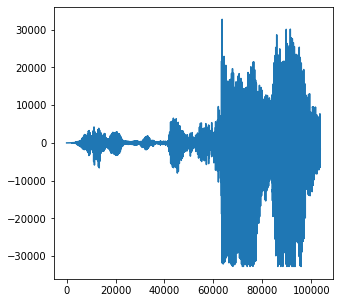

1/1 [==============================] - 0s 473ms/step

The Emotion Predicted For Recorded Audio Using Microphone is ['angry']
The recommended learning mode is 2
Total time required: 8138.124 ms


In [ ]:
test_realtime(encoder)